In [1]:
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
import pandas as pd
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired
import torch
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from gensim import corpora
from langdetect import detect_langs, LangDetectException, DetectorFactory
import os
import glob
import gc
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objects as go  # Import plotly's graph objects
from typing import List, Union
from IPython.display import display, HTML
os.environ["TOKENIZERS_PARALLELISM"] = "false"

/opt/homebrew/anaconda3/envs/landscape/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir('/Users/lhampton/Documents/Local_Projects/ailandscapeproject')

In [3]:
os.chdir('/Users/lhampton/Library/CloudStorage/GoogleDrive-lucyjhampton5@gmail.com/.shortcut-targets-by-id/1EznD-uaTblXtaIVx04-toZMQh7cQf9hA/AI Landscape Large Files/Data/constructed/combined_topic_modeling')
pub_output_dir = '/Users/lhampton/Library/CloudStorage/GoogleDrive-lucyjhampton5@gmail.com/.shortcut-targets-by-id/1EznD-uaTblXtaIVx04-toZMQh7cQf9hA/AI Landscape Large Files/Data/constructed/pub_topic_modeling'
wp_output_dir = '/Users/lhampton/Library/CloudStorage/GoogleDrive-lucyjhampton5@gmail.com/.shortcut-targets-by-id/1EznD-uaTblXtaIVx04-toZMQh7cQf9hA/AI Landscape Large Files/Data/constructed/wp_topic_modeling'
constr_wp_dir = '/Users/lhampton/Library/CloudStorage/GoogleDrive-lucyjhampton5@gmail.com/.shortcut-targets-by-id/1EznD-uaTblXtaIVx04-toZMQh7cQf9hA/AI Landscape Large Files/Data/constructed/wp_classification'
constr_pub_dir = '/Users/lhampton/Library/CloudStorage/GoogleDrive-lucyjhampton5@gmail.com/.shortcut-targets-by-id/1EznD-uaTblXtaIVx04-toZMQh7cQf9hA/AI Landscape Large Files/Data/constructed/pub_classification'
orig_wp_dir = "/Users/lhampton/Library/CloudStorage/GoogleDrive-lucyjhampton5@gmail.com/.shortcut-targets-by-id/1EznD-uaTblXtaIVx04-toZMQh7cQf9hA/AI Landscape Large Files/Data/original/working_papers"
orig_pub_dir = "/Users/lhampton/Library/CloudStorage/GoogleDrive-lucyjhampton5@gmail.com/.shortcut-targets-by-id/1EznD-uaTblXtaIVx04-toZMQh7cQf9hA/AI Landscape Large Files/Data/original/published_papers"

# Load the data

## Published papers

In [4]:
pub_data_full = pd.read_csv(f"{orig_pub_dir}/no_duplicates.csv", index_col = 0).reset_index()
pub_data_full = pub_data_full[['Abstract', 'Article Title', 'Authors or Inventors']]
pub_data_full = pub_data_full.rename(columns = {'Abstract': 'abstract', 'Authors or Inventors' : 'author', 'Article Title': 'title'})

pub_data = pd.read_csv(f'{constr_pub_dir}/relevant_pubs.csv', index_col = 0)
pub_data = pub_data[['Abstract', 'DOI', 'Cited by', 'Publication Year']]
pub_data = pub_data.rename(columns={'Abstract': 'abstract'})

pub_data = pd.merge(pub_data, pub_data_full, on = 'abstract', how = 'left')
pub_data = pub_data.rename(columns = {'Publication Year' : 'year'})
pub_data

,abstract,DOI,Cited by,year,title,author
0,"For employees, work involves taking breaks as ...",10.4018/JOEUC.329596,1,2023,The Shape of Workbreaks to Come: Reframing Cyb...,Oravec J.A.
1,The term 'artificial intelligence' (AI) refers...,10.1109/ICONSTEM60960.2024.10568724,0,2024,A Novel Approach of Data-Driven Strategic Deci...,Umamaheswari S.; Valarmathi A.; Dhinakaran D.P...
2,This study aims to explore how firms' innovati...,10.1504/IJTM.2020.112122,5,2020,How to become the chosen one in the artificial...,Li J.; Liu Z.; Zhou J.
3,This research aims to investigate the acceptan...,10.4018/IJEBR.323796,0,2023,A Study of Customer Acceptance of Artificial I...,Choi Y.
4,Generative AI appears poised to transform whit...,10.1145/3630106.3658987,0,2024,The Impact and Opportunities of Generative AI ...,Wolfe R.; Mitra T.
...,...,...,...,...,...,...
3594,"Since the introduction of ChatGPT, the leading...",10.1016/j.jbusres.2024.114720,2,2024,Artificial intelligence and consumer behavior:...,Hermann E.; Puntoni S.
3595,IBM has deployed its Predictive Analytics for ...,10.1287/INTE.2020.1064,1,2021,IBM predictive analytics reduces server downtime,Bogojeska J.; Giurgiu I.; Stark G.; Wiesmann D.
3596,Natural resources have long been considered a ...,10.1016/j.resourpol.2024.104831,0,2024,Nonlinear relationship between natural resourc...,Xie T.; Xu Y.; Li Y.
3597,Purpose: This study aims to explore the role t...,10.1108/IJRDM-12-2022-0493,7,2023,The role of artificial intelligence in improvi...,Calvo A.V.; Franco A.D.; Frasquet M.


## Working papers

In [5]:
wp_data_both = pd.read_csv(f"{constr_wp_dir}/classed_wps_3.csv", index_col = 0).reset_index()
wp_data_As = wp_data_both[wp_data_both['GPT_class'] == "A"][['abstract']].drop_duplicates('abstract')
wp_data_full = pd.read_csv(f"{orig_wp_dir}/working_papers.csv", index_col = 0).drop_duplicates('abstract')
wp_data_As = pd.merge(wp_data_As, wp_data_full, how = 'left', on = 'abstract')
print("length of base data: ", len(wp_data_As))

# add citations
wp_data_cits_dois = pd.read_csv(f"{orig_wp_dir}/citations.csv", index_col=0).drop_duplicates(subset = ['doi'])
wp_data = pd.merge(wp_data_As, wp_data_cits_dois, on = 'doi', how = 'left')

wp_data_cits_abstracts = pd.read_csv(f"{orig_wp_dir}/citations_abstracts.csv", index_col=0).drop_duplicates(subset=['abstract'])
wp_data_cits_abstracts = wp_data_cits_abstracts.rename(columns = {'abstract' : 'abstract_short'}) # this contains only the first 500 letters of the abstract
wp_data['abstract_short'] = wp_data['abstract'].str[:500]
wp_data = pd.merge(wp_data, wp_data_cits_abstracts, on = 'abstract_short', how = 'left') 

wp_data['Cited by'] = wp_data['citation_count_x'].fillna(wp_data['citation_count_y'])
wp_data = wp_data.drop(columns=['citation_count_x', 'citation_count_y'])

# drop duplicates, and drop abstracts with no citations
wp_data = wp_data.drop_duplicates('abstract')
wp_data = wp_data.dropna(subset = 'Cited by')
print("length of data with citations: ", len(wp_data))

# change column names to be consistent with pub_data
wp_data = wp_data.rename(columns = {'doi' : 'DOI'})
wp_data = wp_data.drop(columns = ['abstract_short', 'ID', 'Source', 'link'])
wp_data

length of base data:  1200
length of data with citations:  1039


,abstract,title,author,DOI,year,Cited by
0,Do stronger intellectual property rights incen...,do stronger ipr incentivize female participati...,"higgins, matthew j",10.3386/w32547,2024.0,0.0
1,Drawing insights from the field of innovation ...,"old moats for new models: openness, control, a...","nagaraj, abhishek",10.3386/w32474,2024.0,32.0
2,How will the emergence of ChatGPT and other fo...,artificial intelligence and the skill premium,"veruete, mario",10.3386/w32430,2024.0,19.0
3,David Ricardo initially believed machinery wou...,learning from ricardo and thompson: machinery ...,"johnson, simon",10.3386/w32416,2024.0,8.0
4,Timely and accurate measurement of AI use by f...,tracking firm use of ai in real time: a snapsh...,"savage, keith",10.3386/w32319,2024.0,23.0
...,...,...,...,...,...,...
1195,Can artificial intelligence (AI) assist human ...,when and how artificial intelligence augments ...,"jia, nan, luo, xueming , fang, zheng, liao, ch...",10.2139/ssrn.4397280,2023.0,237.0
1196,This paper looks at transparency and fintech t...,demystifying consumer-facing fintech: accounta...,"paterson, jeannie marie, miller, tim, lyons, h...",NaN,2023.0,1.0
1197,The knowledge-based and data-driven economy re...,digital trade: is data treaty-ready?,"ciuriak, dan",10.2139/ssrn.3110785,2018.0,42.0
1198,Credit risk is probably the most regulated app...,credit risk and artificial intelligence: on th...,"bravo, cristián, calabrese, raffaella, lessman...",10.2139/ssrn.4615412,2023.0,1.0


## Combine

In [6]:
data = pd.concat([wp_data, pub_data])
data = data.drop_duplicates('abstract')
data

,abstract,title,author,DOI,year,Cited by
0,Do stronger intellectual property rights incen...,do stronger ipr incentivize female participati...,"higgins, matthew j",10.3386/w32547,2024.0,0.0
1,Drawing insights from the field of innovation ...,"old moats for new models: openness, control, a...","nagaraj, abhishek",10.3386/w32474,2024.0,32.0
2,How will the emergence of ChatGPT and other fo...,artificial intelligence and the skill premium,"veruete, mario",10.3386/w32430,2024.0,19.0
3,David Ricardo initially believed machinery wou...,learning from ricardo and thompson: machinery ...,"johnson, simon",10.3386/w32416,2024.0,8.0
4,Timely and accurate measurement of AI use by f...,tracking firm use of ai in real time: a snapsh...,"savage, keith",10.3386/w32319,2024.0,23.0
...,...,...,...,...,...,...
3594,"Since the introduction of ChatGPT, the leading...",Artificial intelligence and consumer behavior:...,Hermann E.; Puntoni S.,10.1016/j.jbusres.2024.114720,2024.0,2.0
3595,IBM has deployed its Predictive Analytics for ...,IBM predictive analytics reduces server downtime,Bogojeska J.; Giurgiu I.; Stark G.; Wiesmann D.,10.1287/INTE.2020.1064,2021.0,1.0
3596,Natural resources have long been considered a ...,Nonlinear relationship between natural resourc...,Xie T.; Xu Y.; Li Y.,10.1016/j.resourpol.2024.104831,2024.0,0.0
3597,Purpose: This study aims to explore the role t...,The role of artificial intelligence in improvi...,Calvo A.V.; Franco A.D.; Frasquet M.,10.1108/IJRDM-12-2022-0493,2023.0,7.0


In [7]:
DetectorFactory.seed = 42

# Remove non-english abstracts
def is_english(text, threshold=0.65):
    """
    Determines whether a text is predominantly English.

    Parameters:
      text (str): The text to analyse.
      threshold (float): The minimum total probability for English for the text to be considered English.

    Returns:
      bool: True if the cumulative probability of English is at least the threshold, otherwise False.
    """
    try:
        # Skip empty or missing abstracts
        if pd.isna(text) or text.strip() == '':
            return False
        # Obtain the list of detected languages with their probabilities
        lang_probs = detect_langs(text)
        # Calculate the total probability of the text being English
        en_prob = sum(lang.prob for lang in lang_probs if lang.lang == 'en')
        return en_prob >= threshold
    except LangDetectException:
        # If there is an error during language detection, assume it's not English
        return False
    
# apply to first 50 words of each abstract
data['Abstract_Short'] = data['abstract'].apply(lambda x: ' '.join(str(x).split()[:50]) if pd.notna(x) else '')
english_mask = data['Abstract_Short'].apply(lambda x: is_english(x) if pd.notna(x) else False)

# apply to last 50 words of each abstract
data['Abstract_Short_last'] = data['abstract'].apply(lambda x: ' '.join(str(x).split()[-50:]) if pd.notna(x) else '')
english_mask_last = data['Abstract_Short_last'].apply(lambda x: is_english(x) if pd.notna(x) else False)

# Create a dataframe of non-English abstracts 
non_english_abstracts = data[~(english_mask & english_mask_last)][['abstract', 'Abstract_Short']]

# Print the short abstracts of all removed papers
print("Short abstracts of removed non-English papers:")
for idx, row in non_english_abstracts.iterrows():
    print(f"Index {idx}: {row['abstract']}")

print(f"Removing {len(data) - len(data[english_mask & english_mask_last])} non-English abstracts")
data = data[english_mask & english_mask_last]
data.reset_index(drop=True, inplace=True)

Short abstracts of removed non-English papers:
Index 121: Korean Abstract: 본 연구는 4차 산업혁명 시대의 새로운 변화 속에 미국, 유럽(EU), 일본 등 선진국의 제도적 대응을 살펴보고, 이것이 우리에게 시사하는 바를 도출하는 데 연구 목적이 있다. 인터넷ㆍ스마트폰의 보급, 사물인터넷(IoT)의 발전 등으로 디지털 형식의 수많은 데이터가 대량으로 축적되고 있으며, 양질의 빅데이터 보유 여부가 기업과 국가의 경쟁력을 좌우하는 중요 요소 중 하나로 각광받고 있다. 이와 함께 빅데이터를 조합하고 분석하여 새로운 가치를 창출하는 인공지능(AI)의 역할이 증대되면서 이에 따른 지식재산권 보호 문제가 대두되고 있다. 이와 함께 각종 시스템ㆍ플랫폼상의 상호운용성을 극대화하기 위한 표준화 작업의 중요성 또한 증대되고 있다. 이에 따라 본 보고서에서는 빅데이터, 지식재산권, 표준 분야를 선정하여 새롭게 등장하고 있는 쟁점을 분석한 다음, 이 분야에서 선진적인 제도 대응을 취하고 있는 주요 국가의 법ㆍ제도 동향을 살펴보았다. 제2장에서는 혁신성장 관련 데이터 법ㆍ제도와 관련하여 최근 부상하는 쟁점과 이에 선도적으로 대처하고 있는 주요국의 대응을 쟁점별로 살펴보았다. 데이터 시대의 도래로 인한 데이터의 자산화와 데이터를 통한 산업 발전에 있어 당면 과제인 ① 개인정보 보호와 활용의 균형 ② 데이터세트의 확보 및 활용 ③ 빅데이터 관련 독과점 방지 ④ 국경간 데이터 이전과 조화 문제 등을 식별하고, 이에 대한 주요국의 데이터 법ㆍ제도를 분석하였다. 구체적으로 개인정보보호와 활용에 있어서 우리나라의 ｢개인정보보호법｣은 엄격한 옵트인 방식으로 인해 데이터 수집 및 활용이 어려운바, 실질적 보호를 추구하면서도 활용을 확대할 수 있도록 가명정보의 활용 가능성을 열어주고 이에 대한 안전장치를 마련할 필요가 있다. 데이터세트의 확보 및 활용과 관련하여 개인정보에 대한 권한을 정보주체에게 돌려주어 데이터 활용을 혁신적으로 제고할 수 

In [8]:
# Define docs

documents = data['abstract']
documents = documents.reset_index(drop=True)
documents = documents.tolist()
documents = [str(doc) for doc in documents if isinstance(doc, str)]

# Setup Topic Model

## Compute embeddings

In [9]:
# Setup GPU and Embedder

# Check if MPS (Metal Performance Shaders) is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) for GPU acceleration")
    print(f"PyTorch version: {torch.__version__}")
    print(f"Current device: {device}")
    print(f"MPS device available: {torch.backends.mps.is_available()}")
    print(f"MPS device built: {torch.backends.mps.is_built()}")
else:
    device = torch.device("cpu")
    print("MPS not available, using CPU")

# Setup GPU Embedder
class GPUEmbedder:
    def __init__(self, model_name="all-roberta-large-v1"):
        self.model = SentenceTransformer(model_name).to(device)
        print(f"Model loaded on device: {next(self.model.parameters()).device}")
        
    def __call__(self, documents):
        return self.model.encode(documents, show_progress_bar=True)

# Initialize the embedding model and generate embeddings
print("\nInitializing embedder and generating embeddings...")
embedder = GPUEmbedder()
embeddings = embedder(documents)
embeddings = embeddings.astype(np.float64)
print(f"Embeddings shape: {embeddings.shape}")
print("Embeddings generated successfully!")

Using MPS (Metal Performance Shaders) for GPU acceleration
PyTorch version: 2.5.1
Current device: mps
MPS device available: True
MPS device built: True

Initializing embedder and generating embeddings...
Model loaded on device: mps:0


Batches: 100%|██████████| 144/144 [06:03<00:00,  2.52s/it]

Embeddings shape: (4608, 1024)
Embeddings generated successfully!


## Define topic model

In [10]:
# function for getting topic model
def create_topic_model(documents, min_cluster_size, embeddings):
  hdbscan_model = HDBSCAN(
    min_cluster_size=min_cluster_size,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,
    core_dist_n_jobs=-1
  )

  umap_model = UMAP(
    n_neighbors=15, 
    n_components=5, 
    metric='cosine', 
    random_state=42, 
    low_memory=False,  # Set to False for GPU usage
    n_jobs=-1
   )

  # Initialise the BERTopic model
  topic_model = BERTopic(
      embedding_model=None,
      umap_model=umap_model,
      hdbscan_model=hdbscan_model,
      vectorizer_model=CountVectorizer(stop_words="english"),
      ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
  )

  # Fit the model on your data
  topics, probs = topic_model.fit_transform(documents, embeddings)

  # return topics, probs, topic model
  return topics, probs, topic_model

## Calculate coherence score

In [11]:
def calculate_coherence_score(topic_model, docs):
    # Set device appropriately for your Mac
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    
    # Preprocess documents
    cleaned_docs = topic_model._preprocess_text(docs)
    
    # Extract vectorizer from BERTopic
    vectorizer = topic_model.vectorizer_model
    
    # Initialize tokenizer
    tokenizer = vectorizer.build_tokenizer()
    
    # Tokenize documents
    tokens = []
    batch_size = 100  # Process in batches to show progress
    for i in range(0, len(cleaned_docs), batch_size):
        batch = cleaned_docs[i:i+batch_size]
        batch_tokens = [tokenizer(doc) for doc in batch]
        tokens.extend(batch_tokens)
    
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    
    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names_out()
    
    # Get topic words 
    topic_words = [[words for words, _ in topic_model.get_topic(topic)]
                  for topic in range(len(set(topic_model.topics_))-1)]
    
    # Create coherence model
    coherence_model = CoherenceModel(
        topics=topic_words,
        texts=tokens,
        corpus=corpus,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    # Compute coherence
    coherence = coherence_model.get_coherence()
    
    return coherence

Min cluster size: 10, Coherence: 0.5443646992506751, Number of uncategorized: 1402
Min cluster size: 15, Coherence: 0.6318623836740569, Number of uncategorized: 1202
Min cluster size: 20, Coherence: 0.6542927356857, Number of uncategorized: 1095
Min cluster size: 25, Coherence: 0.6882423110234377, Number of uncategorized: 1376
Min cluster size: 30, Coherence: 0.6959849478229679, Number of uncategorized: 1568
Min cluster size: 35, Coherence: 0.693741492192896, Number of uncategorized: 1646


<Figure size 640x480 with 0 Axes>

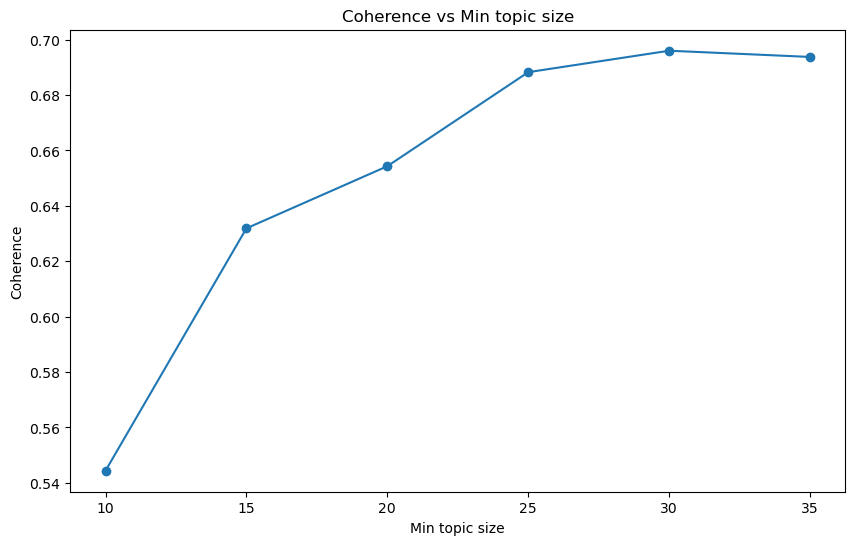

In [ ]:
## Plot coherence score
# Define parameter range for min_cluster_size
min_cluster_sizes = range(10, 40, 5)
coherences = []
num_topics = []
min_clusters = []
uncategorized_topics = []

for min_cluster_size in min_cluster_sizes:
    # Get topic model
    topics, probs, topic_model = create_topic_model(documents, min_cluster_size, embeddings)

    # Get coherence and uncategorized topics
    coherence = calculate_coherence_score(topic_model, documents)
    uncategorized = topics.count(-1)

    # Append to list
    coherences.append(coherence)
    num_topics.append(len(set(topics)) - (1 if -1 in topics else 0))  # Number of topics
    min_clusters.append(min_cluster_size)
    uncategorized_topics.append(uncategorized)
    print(f"Min cluster size: {min_cluster_size}, Coherence: {coherence}, Number of uncategorized: {uncategorized}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(min_clusters, coherences, marker='o')
plt.xlabel("Min topic size")
plt.ylabel("Coherence")
plt.title("Coherence vs Min topic size")
plt.savefig('coherence_plot.png')
plt.show()

## Create optimal topic model and save

In [13]:
# choose topic size and run, this is the best model
topics, probs, topic_model = create_topic_model(documents, 30, embeddings)
topic_df = topic_model.get_topic_info()
topic_df

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1568,-1_ai_human_intelligence_digital,"[ai, human, intelligence, digital, data, artif...",[Purpose: The world is witnessing the advent o...
1,0,400,0_labor_employment_workers_labour,"[labor, employment, workers, labour, automatio...",[Purpose: The purpose of the study is to inves...
2,1,275,1_financial_banking_banks_credit,"[financial, banking, banks, credit, fintech, s...","[In today’s economic landscape, the challenges..."
3,2,215,2_40_manufacturing_production_i40,"[40, manufacturing, production, i40, maintenan...",[Research background: With increasing evidence...
4,3,211,3_supply_chain_logistics_resilience,"[supply, chain, logistics, resilience, scm, ch...",[The emergence of Industry 5.0 has ushered in ...
5,4,203,4_business_innovation_organizational_capabilities,"[business, innovation, organizational, capabil...",[Purpose: This study aims to predict artificia...
6,5,201,5_chatgpt_generative_llms_students,"[chatgpt, generative, llms, students, language...",[Purpose: This article aims to explore the adv...
7,6,192,6_hr_hrm_recruitment_talent,"[hr, hrm, recruitment, talent, employee, resou...","[Purpose: With the recent proliferation of AI,..."
8,7,174,7_healthcare_medical_health_patient,"[healthcare, medical, health, patient, care, c...","[Purpose: Nowadays, the digitized economy and ..."
9,8,160,8_gpt_patents_patent_innovation,"[gpt, patents, patent, innovation, gpts, knowl...","[Leading experts from academic, industrial and..."


##  Reduce outliers

Calculating initial topic assignments...
Found 1568 outliers.
{-1: [('ai', 0.1687973800825558), ('human', 0.16870646435125572), ('intelligence', 0.16832440368799448), ('digital', 0.16807630063808632), ('data', 0.16769139213199688), ('artificial', 0.16704705538543435), ('study', 0.1653334481776355), ('research', 0.16415996442775627), ('innovation', 0.1629698346280929), ('technology', 0.16103013898561302)], 0: [('labor', 0.36816138670557963), ('employment', 0.3530811870562371), ('workers', 0.32214528708326007), ('labour', 0.32021273526547295), ('automation', 0.3045662993777055), ('occupations', 0.29086881354308014), ('jobs', 0.27608592500062046), ('unemployment', 0.27514307963226764), ('wages', 0.27403358258871424), ('growth', 0.2662768515359544)], 1: [('financial', 0.4468447873985913), ('banking', 0.4086006099170633), ('banks', 0.3561607644689144), ('credit', 0.3285738589930114), ('fintech', 0.2979670146939425), ('services', 0.263940300514022), ('finance', 0.26334927011683157), ('instit

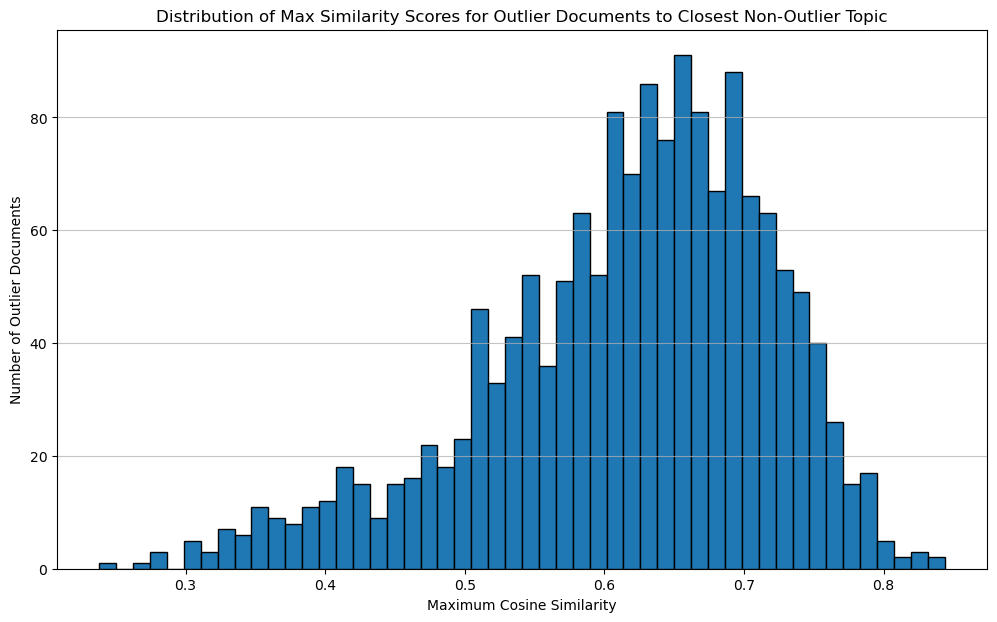


Descriptive Statistics for Maximum Similarities:
count    1568.000000
mean        0.616065
std         0.103683
min         0.238244
25%         0.556624
50%         0.631879
75%         0.691527
90%         0.735140
95%         0.755375
99%         0.793902
max         0.843753
dtype: float64


In [14]:
print("Calculating initial topic assignments...")
# Get topics assigned before any outlier reduction attempts
initial_topics, _ = topic_model.transform(documents, embeddings=embeddings)

# 1. Identify outliers and their embeddings from the initial run
outlier_indices = np.where(np.array(initial_topics) == -1)[0]

if len(outlier_indices) > 0:
    print(f"Found {len(outlier_indices)} outliers.")
    outlier_embeddings = embeddings[outlier_indices]

    # 2. Get topic embeddings (corresponding to the initial topics)
    # Ensure topic_embeddings_ exists and is not empty
    if hasattr(topic_model, 'topic_embeddings_') and topic_model.topic_embeddings_ is not None and len(topic_model.topic_embeddings_) > 0:
        topic_embeddings = topic_model.topic_embeddings_
        
        # Filter out the outlier topic (-1) if it exists in topic_embeddings_
        topic_indices = [idx for idx in range(len(topic_embeddings)) 
                         if idx in topic_model.topic_representations_ and idx != -1]
        print(topic_model.topic_representations_)
        
        # Only use embeddings for actual topics (not the outlier topic)
        filtered_topic_embeddings = topic_embeddings[topic_indices]

        # 3. Calculate similarities between outliers and non-outlier topics
        print("Calculating similarities between outliers and non-outlier topics...")
        similarities = cosine_similarity(outlier_embeddings, filtered_topic_embeddings)

        # 4. Find maximum similarity for each outlier
        max_similarities = np.max(similarities, axis=1)

        # 5. Plot distribution
        print("Plotting similarity distribution...")
        plt.figure(figsize=(12, 7))
        plt.hist(max_similarities, bins=50, edgecolor='black')
        plt.title('Distribution of Max Similarity Scores for Outlier Documents to Closest Non-Outlier Topic')
        plt.xlabel('Maximum Cosine Similarity')
        plt.ylabel('Number of Outlier Documents')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

        # Print some descriptive statistics
        print("\nDescriptive Statistics for Maximum Similarities:")
        stats = pd.Series(max_similarities).describe(percentiles=[.25, .5, .75, .90, .95, .99])
        print(stats)

    else:
        print("Could not find valid topic embeddings in the model to compare against.")

else:
    print("No outliers found in the initial topic assignment.")

In [15]:
#  Choose threshold

for threshold in [0.55, 0.6, 0.65, 0.67, 0.68, 0.69, 0.7]:
    print("Threshold: ", threshold)
    #  Reduce outliers
    new_topics = topic_model.reduce_outliers(documents, topics, embeddings = embeddings, strategy="embeddings", threshold=threshold)

    # update
    topic_model.update_topics(documents, topics=new_topics)

    # calc coherence
    coherence = calculate_coherence_score(topic_model, documents)
    print("Coherence score: ", coherence)

    # Count the number of documents per topic
    topic_counts = pd.Series(new_topics).value_counts().sort_index()

    # Display the counts
    print("Number of documents per topic:")
    print(topic_counts)

Threshold:  0.55


2025-05-06 10:54:54,647 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-05-06 10:55:07,136 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Coherence score:  0.3723379691385375
Number of documents per topic:
-1     377
 0     458
 1     321
 2     244
 3     250
 4     425
 5     230
 6     261
 7     186
 8     253
 9     178
 10    122
 11    118
 12    247
 13    125
 14    193
 15    121
 16     92
 17    105
 18    138
 19    115
 20     49
Name: count, dtype: int64
Threshold:  0.6


2025-05-06 10:55:18,603 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Coherence score:  0.368237736733341
Number of documents per topic:
-1     600
 0     446
 1     308
 2     235
 3     242
 4     399
 5     218
 6     250
 7     185
 8     231
 9     174
 10    113
 11    112
 12    227
 13    121
 14    174
 15    113
 16     85
 17     99
 18    121
 19    106
 20     49
Name: count, dtype: int64
Threshold:  0.65


2025-05-06 10:55:30,871 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Coherence score:  0.3701852774906841
Number of documents per topic:
-1     925
 0     431
 1     294
 2     223
 3     230
 4     339
 5     206
 6     240
 7     181
 8     197
 9     169
 10    108
 11    109
 12    186
 13    118
 14    143
 15     92
 16     78
 17     90
 18    112
 19     90
 20     47
Name: count, dtype: int64
Threshold:  0.67


2025-05-06 10:55:44,005 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Coherence score:  0.3748459173379414
Number of documents per topic:
-1     1057
 0      428
 1      288
 2      221
 3      225
 4      308
 5      203
 6      231
 7      179
 8      190
 9      167
 10     107
 11     107
 12     174
 13     115
 14     129
 15      87
 16      74
 17      84
 18     104
 19      83
 20      47
Name: count, dtype: int64
Threshold:  0.68


2025-05-06 10:55:56,479 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Coherence score:  0.3757433925153531
Number of documents per topic:
-1     1110
 0      423
 1      286
 2      220
 3      223
 4      296
 5      202
 6      227
 7      178
 8      187
 9      166
 10     107
 11     107
 12     172
 13     115
 14     127
 15      84
 16      73
 17      83
 18      97
 19      78
 20      47
Name: count, dtype: int64
Threshold:  0.69


2025-05-06 10:56:09,137 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Coherence score:  0.3750640501449509
Number of documents per topic:
-1     1176
 0      421
 1      283
 2      217
 3      219
 4      285
 5      202
 6      222
 7      177
 8      181
 9      165
 10     105
 11     107
 12     165
 13     112
 14     124
 15      83
 16      73
 17      79
 18      91
 19      74
 20      47
Name: count, dtype: int64
Threshold:  0.7
Coherence score:  0.37871288238326417
Number of documents per topic:
-1     1247
 0      415
 1      283
 2      217
 3      217
 4      270
 5      201
 6      216
 7      176
 8      180
 9      163
 10     105
 11     106
 12     154
 13     110
 14     117
 15      80
 16      71
 17      76
 18      84
 19      73
 20      47
Name: count, dtype: int64


In [16]:
# choose topic size and run, this is the best model
topics, probs, topic_model = create_topic_model(documents, 20, embeddings)
new_topics = topic_model.reduce_outliers(documents, topics, embeddings = embeddings, strategy="embeddings", threshold=0.65)
topic_model.update_topics(documents, topics=new_topics, vectorizer_model=CountVectorizer(stop_words="english"))
topic_df = topic_model.get_topic_info()
topic_df.to_csv('topics_combined.csv')
topic_df

2025-05-06 10:56:25,956 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


,Topic,Count,Name,Representation,Representative_Docs
0,-1,585,-1_ai_digital_data_artificial,"[ai, digital, data, artificial, intelligence, ...","[In recent years, investments in technology ha..."
1,0,406,0_labor_employment_workers_automation,"[labor, employment, workers, automation, ai, l...","[It is claimed that robots, algorithms and art..."
2,1,399,1_employees_hr_ai_employee,"[employees, hr, ai, employee, job, hrm, human,...",[The present study is focused on investigating...
3,2,321,2_financial_banking_banks_credit,"[financial, banking, banks, credit, services, ...",[The contemporary financial landscape is witne...
4,3,313,3_ai_business_innovation_adoption,"[ai, business, innovation, adoption, value, in...",[Purpose: Innovative firms have rapidly develo...
5,4,234,4_supply_chain_logistics_resilience,"[supply, chain, logistics, resilience, managem...",[This study presents a comprehensive investiga...
6,5,226,5_manufacturing_40_industry_production,"[manufacturing, 40, industry, production, tech...",[Considering the increase in the stakeholders’...
7,6,200,6_chatgpt_generative_llms_students,"[chatgpt, generative, llms, students, educatio...",[Purpose: This article aims to explore the adv...
8,7,228,7_innovation_data_firms_ai,"[innovation, data, firms, ai, patent, patents,...","[Leading experts from academic, industrial and..."
9,8,186,8_healthcare_medical_health_care,"[healthcare, medical, health, care, ai, patien...","[Purpose: Nowadays, the digitized economy and ..."


In [17]:
# Check if necessary variables exist
required_vars = ['topics', 'new_topics', 'documents', 'topic_model', 'embeddings']
missing_vars = [var for var in required_vars if var not in locals() and var not in globals()]

if missing_vars:
    print(f"Error: One or more required variables not found: {missing_vars}")
    print("Please ensure the cell that defines the final model (e.g., execution_count 254) and earlier cells defining 'documents' and 'embeddings' have been run.")
else:
    print("Required variables found. Proceeding...")

    # Convert topics to numpy arrays for efficient comparison
    initial_topics_array = np.array(topics) # Using 'topics' from the final cell as initial
    final_topics_array = np.array(new_topics) # Using 'new_topics' from the final cell as final

    # 1. Find indices of initial outliers (using 'topics')
    initial_outlier_indices = np.where(initial_topics_array == -1)[0]

    # 2. Find indices of final non-outliers (using 'new_topics')
    final_non_outlier_indices = np.where(final_topics_array != -1)[0]

    # 3. Find indices of documents that *changed* from outlier to non-outlier
    changed_indices = np.array(list(set(initial_outlier_indices) & set(final_non_outlier_indices)))

    print(f"\nFound {len(changed_indices)} documents that were reassigned from outliers when applying the final threshold (0.7).")

    reassigned_data = [] # List to store data for CSV

    if len(changed_indices) > 0:
        print(f"Processing {len(changed_indices)} reassigned documents for CSV output...")

        # Ensure documents is indexable
        if not isinstance(documents, (list, np.ndarray, pd.Series)):
            print("Warning: 'documents' might not be in an easily indexable format. Trying to convert to list.")
            try:
                 documents_list = list(documents)
            except TypeError:
                 print("Error: Could not convert 'documents' to a list. Cannot include document text.")
                 documents_list = None
        else:
             documents_list = documents # Use as is if already suitable

        if documents_list is not None:
            for idx in changed_indices: # Process all changed indices
                original_topic = initial_topics_array[idx] # Should be -1
                new_topic = final_topics_array[idx]
                document_text_str = "[Error retrieving document text]" # Default
                topic_words_str = "[Error retrieving topic words]" # Default

                try:
                    # Handle potential conversion if documents is pandas Series vs list/array
                    if isinstance(documents_list, pd.Series):
                        try:
                            document_text_str = str(documents_list.iloc[idx])
                        except IndexError:
                             try:
                                  document_text_str = str(documents_list[idx])
                             except KeyError: pass # Keep default error message
                    else:
                         try:
                            document_text_str = str(documents_list[idx])
                         except IndexError: pass # Keep default error message
                except Exception as e:
                    document_text_str = f"[Error retrieving document text: {e}]"

                try:
                    # Use the FINAL topic_model instance to get words for the NEW topic
                    topic_words = topic_model.get_topic(new_topic)
                    if topic_words: # Check if topic_words is not False or None
                         topic_words_str = ", ".join([f"{word}({score:.3f})" for word, score in topic_words])
                    else:
                         topic_words_str = f"(Topic {new_topic} merged/removed/no words)"
                except ValueError as ve:
                     topic_words_str = f"(Topic {new_topic} invalid: {ve})"
                except Exception as e:
                    topic_words_str = f"(Error retrieving words: {e})"

                reassigned_data.append({
                    'Document Index': idx,
                    'Original Topic': original_topic,
                    'New Topic': new_topic,
                    'New Topic Keywords': topic_words_str,
                    'Document Text': document_text_str
                })
        else:
             print("Cannot process document details because 'documents' could not be processed.")

        # Create DataFrame and save to CSV
        if reassigned_data:
            reassigned_df = pd.DataFrame(reassigned_data)
            csv_filename = 'reassigned_outliers.csv'
            try:
                reassigned_df.to_csv(csv_filename, index=False)
                print(f"\nSuccessfully saved details of {len(reassigned_data)} reassigned documents to '{csv_filename}'")
            except Exception as e:
                print(f"\nError saving data to CSV '{csv_filename}': {e}")
        else:
            print("\nNo data collected to save to CSV.")


    elif len(initial_outlier_indices) > 0:
        print("\nNo documents were reassigned from outliers based on the final threshold application.")
        print(f"(There were {len(initial_outlier_indices)} outliers in the 'topics' variable before the final reduction).")
    else:
         print("\nThere were no initial outliers in the 'topics' variable to reassign.")

Required variables found. Proceeding...

Found 510 documents that were reassigned from outliers when applying the final threshold (0.7).
Processing 510 reassigned documents for CSV output...

Successfully saved details of 510 reassigned documents to 'reassigned_outliers.csv'


In [18]:
# Save the model
with open('combined_model.pkl', 'wb') as f:
    pickle.dump(topic_model, f)

print("Model saved successfully!")

Model saved successfully!


# Label topics and display paper and citation counts

## Label topics

In [19]:
# load model
with open('combined_model.pkl', 'rb') as f:
    topic_model = pickle.load(f)

# Load topics from the model
topics = topic_model.topics_
probs = topic_model.probabilities_

print(f"Loaded {len(topics)} papers and their probabilities from the model")

Loaded 4608 papers and their probabilities from the model


In [20]:
custom_topic_labels = {
    -1: "",
    0: "Automation and Labour",
    1: "Finance and Banking",
    2: "Supply Chains",
    3: "Human Resources and Management",
    4: "Manufacturing",
    5: "Business Adoption",
    6: "Generative AI",
    7: "Healthcare & Medicine",
    8: "Innovation and Patents",
    9: "Tourism and Hospitality",
    10: "Accounting and Auditing",
    11: "Chatbots",
    12: "Green Energy",
    13: "Corporate Disclosure",
    14: "Decision-Making",
    15: "AI Governance and Regulation",
    16: "ESG and Sustainability",
    17: "Construction and Project Management",
    18: "Marketing",
    19: "Employee Awareness",
    20: "Shopping and Retail",
    21: "Agriculture",
    22: "Algorithmic Pricing",
    23: "Services",
    24: "Labour laws",
    25: "Law and lawyers",
    26: "Fairness and Bias",
    27: "Sustainability Goals",
    28: "Public Services",
    29: "Corporate Governance",
    30: "Real Estate",
    31: "Taxation"

}

topic_model.set_topic_labels(custom_topic_labels)

In [21]:
papers_topics = pd.DataFrame({'abstract': documents, 'Topic': topics, 'Probability': probs})
papers_topics = papers_topics.merge(data, on = "abstract", how = "inner")
papers_topics = papers_topics.rename(columns = {"abstract" : "abstract"})
papers_topics.to_csv('papers_topics_combined.csv')
papers_topics

,abstract,Topic,Probability,title,author,DOI,year,Cited by,Abstract_Short,Abstract_Short_last
0,Do stronger intellectual property rights incen...,7,1.0,do stronger ipr incentivize female participati...,"higgins, matthew j",10.3386/w32547,2024.0,0.0,Do stronger intellectual property rights incen...,"heterogeneity at the country, technology class..."
1,Drawing insights from the field of innovation ...,7,0.0,"old moats for new models: openness, control, a...","nagaraj, abhishek",10.3386/w32474,2024.0,32.0,Drawing insights from the field of innovation ...,might help preserve competition and incentives...
2,How will the emergence of ChatGPT and other fo...,0,1.0,artificial intelligence and the skill premium,"veruete, mario",10.3386/w32430,2024.0,19.0,How will the emergence of ChatGPT and other fo...,"AI. Following the literature, we assume that i..."
3,David Ricardo initially believed machinery wou...,0,1.0,learning from ricardo and thompson: machinery ...,"johnson, simon",10.3386/w32416,2024.0,8.0,David Ricardo initially believed machinery wou...,"of productivity growth. Today, artificial inte..."
4,Timely and accurate measurement of AI use by f...,3,0.0,tracking firm use of ai in real time: a snapsh...,"savage, keith",10.3386/w32319,2024.0,23.0,Timely and accurate measurement of AI use by f...,Many firms undergo organizational changes to a...
...,...,...,...,...,...,...,...,...,...,...
4603,"Since the introduction of ChatGPT, the leading...",6,1.0,Artificial intelligence and consumer behavior:...,Hermann E.; Puntoni S.,10.1016/j.jbusres.2024.114720,2024.0,2.0,"Since the introduction of ChatGPT, the leading...","field of GenAI. Here, we differentiate between..."
4604,IBM has deployed its Predictive Analytics for ...,-1,0.0,IBM predictive analytics reduces server downtime,Bogojeska J.; Giurgiu I.; Stark G.; Wiesmann D.,10.1287/INTE.2020.1064,2021.0,1.0,IBM has deployed its Predictive Analytics for ...,We demonstrate the model's effectiveness by co...
4605,Natural resources have long been considered a ...,-1,0.0,Nonlinear relationship between natural resourc...,Xie T.; Xu Y.; Li Y.,10.1016/j.resourpol.2024.104831,2024.0,0.0,Natural resources have long been considered a ...,value of strategic investments in emerging tec...
4606,Purpose: This study aims to explore the role t...,17,1.0,The role of artificial intelligence in improvi...,Calvo A.V.; Franco A.D.; Frasquet M.,10.1108/IJRDM-12-2022-0493,2023.0,7.0,Purpose: This study aims to explore the role t...,This study presents insights on the impact of ...


## Citations

In [22]:
topics_citations_sum = papers_topics[['Cited by', 'Topic']].groupby('Topic').sum().reset_index().rename(columns = {'Cited by':'sum_citations'})
topics_citations_average = papers_topics[['Cited by', 'Topic']].groupby('Topic').mean().reset_index().rename(columns = {'Cited by':'mean_citations'})
topics_citations_median = papers_topics[['Cited by', 'Topic']].groupby('Topic').median().reset_index().rename(columns = {'Cited by':'med_citations'})
topics_citations_max = papers_topics[['Cited by', 'Topic']].groupby('Topic').max().reset_index().rename(columns = {'Cited by':'max_citations'})

topics_citations = pd.merge(topics_citations_sum, topics_citations_average, on = 'Topic', how = 'inner')
topics_citations = pd.merge(topics_citations, topics_citations_median, on = 'Topic', how = 'inner')
topics_citations = pd.merge(topics_citations, topics_citations_max, on = 'Topic', how = 'inner')

topics_citations.sort_values('med_citations', ascending=False)

,Topic,sum_citations,mean_citations,med_citations,max_citations
13,12,4013.0,33.441667,12.0,530.0
10,9,7593.0,44.403509,9.0,558.0
16,15,4250.0,36.956522,7.0,368.0
8,7,7540.0,33.070175,6.0,1618.0
18,17,2151.0,21.510000,6.0,405.0
1,0,19039.0,46.894089,6.0,1994.0
21,20,676.0,19.314286,6.0,132.0
27,26,1782.0,50.914286,6.0,474.0
15,14,4006.0,29.455882,6.0,395.0
4,3,10241.0,32.718850,5.0,582.0


## Questions

In [23]:
questions_wps = pd.read_csv(f'{wp_output_dir}/questions_wps.csv', index_col = 0)
questions_pubs = pd.read_csv(f'{pub_output_dir}/questions_pub.csv', index_col = 0)
papers_topics = papers_topics.merge(questions_pubs, on = "abstract", how = "left")
papers_topics = papers_topics.merge(questions_wps, on = "abstract", how = "left")
papers_topics['Question'] = papers_topics['Question_x'].fillna(papers_topics['Question_y'])
papers_topics = papers_topics.drop(columns = ['Question_x', 'Question_y'])

In [24]:
papers_topics

,abstract,Topic,Probability,title,author,DOI,year,Cited by,Abstract_Short,Abstract_Short_last,Question
0,Do stronger intellectual property rights incen...,7,1.0,do stronger ipr incentivize female participati...,"higgins, matthew j",10.3386/w32547,2024.0,0.0,Do stronger intellectual property rights incen...,"heterogeneity at the country, technology class...",Do stronger intellectual property rights enhan...
1,Drawing insights from the field of innovation ...,7,0.0,"old moats for new models: openness, control, a...","nagaraj, abhishek",10.3386/w32474,2024.0,32.0,Drawing insights from the field of innovation ...,might help preserve competition and incentives...,How will the concepts of appropriability and c...
2,How will the emergence of ChatGPT and other fo...,0,1.0,artificial intelligence and the skill premium,"veruete, mario",10.3386/w32430,2024.0,19.0,How will the emergence of ChatGPT and other fo...,"AI. Following the literature, we assume that i...","How will the emergence of AI, particularly Cha..."
3,David Ricardo initially believed machinery wou...,0,1.0,learning from ricardo and thompson: machinery ...,"johnson, simon",10.3386/w32416,2024.0,8.0,David Ricardo initially believed machinery wou...,"of productivity growth. Today, artificial inte...",What are the complex effects of automation and...
4,Timely and accurate measurement of AI use by f...,3,0.0,tracking firm use of ai in real time: a snapsh...,"savage, keith",10.3386/w32319,2024.0,23.0,Timely and accurate measurement of AI use by f...,Many firms undergo organizational changes to a...,What are the current and expected future rates...
...,...,...,...,...,...,...,...,...,...,...,...
4603,"Since the introduction of ChatGPT, the leading...",6,1.0,Artificial intelligence and consumer behavior:...,Hermann E.; Puntoni S.,10.1016/j.jbusres.2024.114720,2024.0,2.0,"Since the introduction of ChatGPT, the leading...","field of GenAI. Here, we differentiate between...",What is the impact of Generative Artificial In...
4604,IBM has deployed its Predictive Analytics for ...,-1,0.0,IBM predictive analytics reduces server downtime,Bogojeska J.; Giurgiu I.; Stark G.; Wiesmann D.,10.1287/INTE.2020.1064,2021.0,1.0,IBM has deployed its Predictive Analytics for ...,We demonstrate the model's effectiveness by co...,What are the results and effectiveness of IBM'...
4605,Natural resources have long been considered a ...,-1,0.0,Nonlinear relationship between natural resourc...,Xie T.; Xu Y.; Li Y.,10.1016/j.resourpol.2024.104831,2024.0,0.0,Natural resources have long been considered a ...,value of strategic investments in emerging tec...,What is the nonlinear relationship between nat...
4606,Purpose: This study aims to explore the role t...,17,1.0,The role of artificial intelligence in improvi...,Calvo A.V.; Franco A.D.; Frasquet M.,10.1108/IJRDM-12-2022-0493,2023.0,7.0,Purpose: This study aims to explore the role t...,This study presents insights on the impact of ...,What role do artificial intelligence systems p...


# Subtopic modeling

In [25]:
for topic in range(0, len(topic_df)):
  papers = papers_topics[papers_topics['Topic'] == topic][['abstract', 'year', 'Cited by', 'DOI', 'title', 'author', 'Question']]
  subdocuments = papers['abstract']
  subdocuments = subdocuments.reset_index(drop=True)
  subdocuments = subdocuments.tolist()
  if len(subdocuments) > 30:
    gc.collect()
    # Extract the embeddings for just the documents in this topic
    topic_indices = papers_topics[papers_topics['Topic'] == topic].index.tolist()
    topic_embeddings = embeddings[topic_indices]
    
    subtopics, subprobs, sub_topic_model = create_topic_model(subdocuments, 10, topic_embeddings)
    mini_df = pd.DataFrame({'abstract': subdocuments, 'Topic': subtopics})
    mini_df = mini_df.merge(papers, on = 'abstract', how = 'left')
    mini_df.to_csv(f'subtopics/subtopics_{topic}_papers.csv')
    mini_topic_df = sub_topic_model.get_topic_info()
    print(mini_topic_df)
    mini_topic_df.to_csv(f'subtopics/subtopics_{topic}.csv')

    Topic  Count                                             Name  \
0      -1    157                -1_workers_labour_intelligence_ai   
1       0     75               0_risk_occupations_automation_jobs   
2       1     33                     1_growth_capital_labor_share   
3       2     31                  2_postings_vacancies_job_demand   
4       3     28             3_economics_ai_connectivity_economic   
5       4     16          4_robot_manufacturing_robots_industrial   
6       5     14  5_unemployment_intangible_governance_statelevel   
7       6     14            6_wellbeing_conditions_working_health   
8       7     14          7_deficit_adopted_reallocation_european   
9       8     13             8_inequality_air_poor_digitalization   
10      9     11           9_tax_airobots_proposals_jurisdictions   

                                       Representation  \
0   [workers, labour, intelligence, ai, technologi...   
1   [risk, occupations, automation, jobs, er, skil...   


In [26]:
def combine_subtopic_papers(base_path):
    # Define the pattern to match all subtopic paper files
    pattern = os.path.join(base_path, "subtopics_*_papers.csv")

    # Get all matching files
    file_paths = glob.glob(pattern)

    # Create an empty list to store individual dataframes
    all_dfs = []

    # Process each file
    for file_path in file_paths:
        # Extract the main topic number from the filename
        filename = os.path.basename(file_path)
        main_topic = int(filename.split('_')[1])

        # Read the CSV
        df = pd.read_csv(file_path, index_col=0)

        # read topic df description
        topic_df = pd.read_csv(f'subtopics/subtopics_{main_topic}.csv', index_col = 0)
        topic_df = topic_df[['Topic', 'Name']]
        topic_df = topic_df.rename(columns = {'Name': 'subtopic name'})

        # merge with labels
        df = df.merge(topic_df, on = 'Topic', how = 'left')

        # Add a column for the main topic
        df['broad_topic'] = main_topic

        # Append to our list
        all_dfs.append(df)

    # Concatenate all dataframes
    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        return combined_df
    else:
        print("No files found matching the pattern.")
        return None

# Usage
base_directory = 'subtopics/'
papers_subtopics = combine_subtopic_papers(base_directory)

# Save the combined dataframe
if papers_subtopics is not None:
    output_path = os.path.join(base_directory, 'papers_subtopics.csv')
    papers_subtopics = papers_subtopics.rename(columns = {'Topic': 'subtopic'})
    papers_subtopics = papers_subtopics[['abstract', 'subtopic', 'subtopic name']]
    papers_subtopics.to_csv(output_path)
    print(f"Combined dataframe saved to {output_path}")
    print(f"Shape of combined dataframe: {papers_subtopics.shape}")

Combined dataframe saved to subtopics/papers_subtopics.csv
Shape of combined dataframe: (4147, 3)


In [27]:
papers_subtopics

,abstract,subtopic,subtopic name
0,As companies increasingly integrate artificial...,-1,-1_service_ai_value_intelligence
1,"Recently, with the advancement of artificial i...",-1,-1_service_ai_value_intelligence
2,Purpose: Co-creation of services (CCOS) is a c...,-1,-1_service_ai_value_intelligence
3,Purpose: To explain how technology will replac...,-1,-1_service_ai_value_intelligence
4,Artificial intelligence (AI) is rapidly evolvi...,-1,-1_service_ai_value_intelligence
...,...,...,...
4142,Leveraging Artificial Intelligence to support ...,0,0_ai_human_trust_systems
4143,The related literature and industry press sugg...,-1,-1_ai_decisionmaking_learning_suggestions
4144,Explosive growth in big data technologies and ...,-1,-1_ai_decisionmaking_learning_suggestions
4145,"Today, AI is being increasingly used to help h...",0,0_ai_human_trust_systems


In [28]:
papers_topics_full = papers_topics.merge(papers_subtopics, on = ['abstract'], how = 'left')
papers_topics_full.to_csv('papers_topics_full.csv')
papers_topics_full

,abstract,Topic,Probability,title,author,DOI,year,Cited by,Abstract_Short,Abstract_Short_last,Question,subtopic,subtopic name
0,Do stronger intellectual property rights incen...,7,1.0,do stronger ipr incentivize female participati...,"higgins, matthew j",10.3386/w32547,2024.0,0.0,Do stronger intellectual property rights incen...,"heterogeneity at the country, technology class...",Do stronger intellectual property rights enhan...,-1.0,-1_firms_innovation_ai_patent
1,Drawing insights from the field of innovation ...,7,0.0,"old moats for new models: openness, control, a...","nagaraj, abhishek",10.3386/w32474,2024.0,32.0,Drawing insights from the field of innovation ...,might help preserve competition and incentives...,How will the concepts of appropriability and c...,-1.0,-1_firms_innovation_ai_patent
2,How will the emergence of ChatGPT and other fo...,0,1.0,artificial intelligence and the skill premium,"veruete, mario",10.3386/w32430,2024.0,19.0,How will the emergence of ChatGPT and other fo...,"AI. Following the literature, we assume that i...","How will the emergence of AI, particularly Cha...",-1.0,-1_workers_labour_intelligence_ai
3,David Ricardo initially believed machinery wou...,0,1.0,learning from ricardo and thompson: machinery ...,"johnson, simon",10.3386/w32416,2024.0,8.0,David Ricardo initially believed machinery wou...,"of productivity growth. Today, artificial inte...",What are the complex effects of automation and...,-1.0,-1_workers_labour_intelligence_ai
4,Timely and accurate measurement of AI use by f...,3,0.0,tracking firm use of ai in real time: a snapsh...,"savage, keith",10.3386/w32319,2024.0,23.0,Timely and accurate measurement of AI use by f...,Many firms undergo organizational changes to a...,What are the current and expected future rates...,-1.0,-1_ai_business_value_enterprises
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4792,"Since the introduction of ChatGPT, the leading...",6,1.0,Artificial intelligence and consumer behavior:...,Hermann E.; Puntoni S.,10.1016/j.jbusres.2024.114720,2024.0,2.0,"Since the introduction of ChatGPT, the leading...","field of GenAI. Here, we differentiate between...",What is the impact of Generative Artificial In...,0.0,0_chatgpt_generative_ai_models
4793,IBM has deployed its Predictive Analytics for ...,-1,0.0,IBM predictive analytics reduces server downtime,Bogojeska J.; Giurgiu I.; Stark G.; Wiesmann D.,10.1287/INTE.2020.1064,2021.0,1.0,IBM has deployed its Predictive Analytics for ...,We demonstrate the model's effectiveness by co...,What are the results and effectiveness of IBM'...,NaN,NaN
4794,Natural resources have long been considered a ...,-1,0.0,Nonlinear relationship between natural resourc...,Xie T.; Xu Y.; Li Y.,10.1016/j.resourpol.2024.104831,2024.0,0.0,Natural resources have long been considered a ...,value of strategic investments in emerging tec...,What is the nonlinear relationship between nat...,NaN,NaN
4795,Purpose: This study aims to explore the role t...,17,1.0,The role of artificial intelligence in improvi...,Calvo A.V.; Franco A.D.; Frasquet M.,10.1108/IJRDM-12-2022-0493,2023.0,7.0,Purpose: This study aims to explore the role t...,This study presents insights on the impact of ...,What role do artificial intelligence systems p...,0.0,0_experience_study_online_shopping


# Visualisations

In [29]:
# Add labels

topic_df['Label'] = topic_df['Topic'].apply(lambda x: custom_topic_labels[x])
topic_df.to_csv('topics_combined.csv')
topic_df

,Topic,Count,Name,Representation,Representative_Docs,Label
0,-1,585,-1_ai_digital_data_artificial,"[ai, digital, data, artificial, intelligence, ...","[In recent years, investments in technology ha...",
1,0,406,0_labor_employment_workers_automation,"[labor, employment, workers, automation, ai, l...","[It is claimed that robots, algorithms and art...",Automation and Labour
2,1,399,1_employees_hr_ai_employee,"[employees, hr, ai, employee, job, hrm, human,...",[The present study is focused on investigating...,Finance and Banking
3,2,321,2_financial_banking_banks_credit,"[financial, banking, banks, credit, services, ...",[The contemporary financial landscape is witne...,Supply Chains
4,3,313,3_ai_business_innovation_adoption,"[ai, business, innovation, adoption, value, in...",[Purpose: Innovative firms have rapidly develo...,Human Resources and Management
5,4,234,4_supply_chain_logistics_resilience,"[supply, chain, logistics, resilience, managem...",[This study presents a comprehensive investiga...,Manufacturing
6,5,226,5_manufacturing_40_industry_production,"[manufacturing, 40, industry, production, tech...",[Considering the increase in the stakeholders’...,Business Adoption
7,6,200,6_chatgpt_generative_llms_students,"[chatgpt, generative, llms, students, educatio...",[Purpose: This article aims to explore the adv...,Generative AI
8,7,228,7_innovation_data_firms_ai,"[innovation, data, firms, ai, patent, patents,...","[Leading experts from academic, industrial and...",Healthcare & Medicine
9,8,186,8_healthcare_medical_health_care,"[healthcare, medical, health, care, ai, patien...","[Purpose: Nowadays, the digitized economy and ...",Innovation and Patents


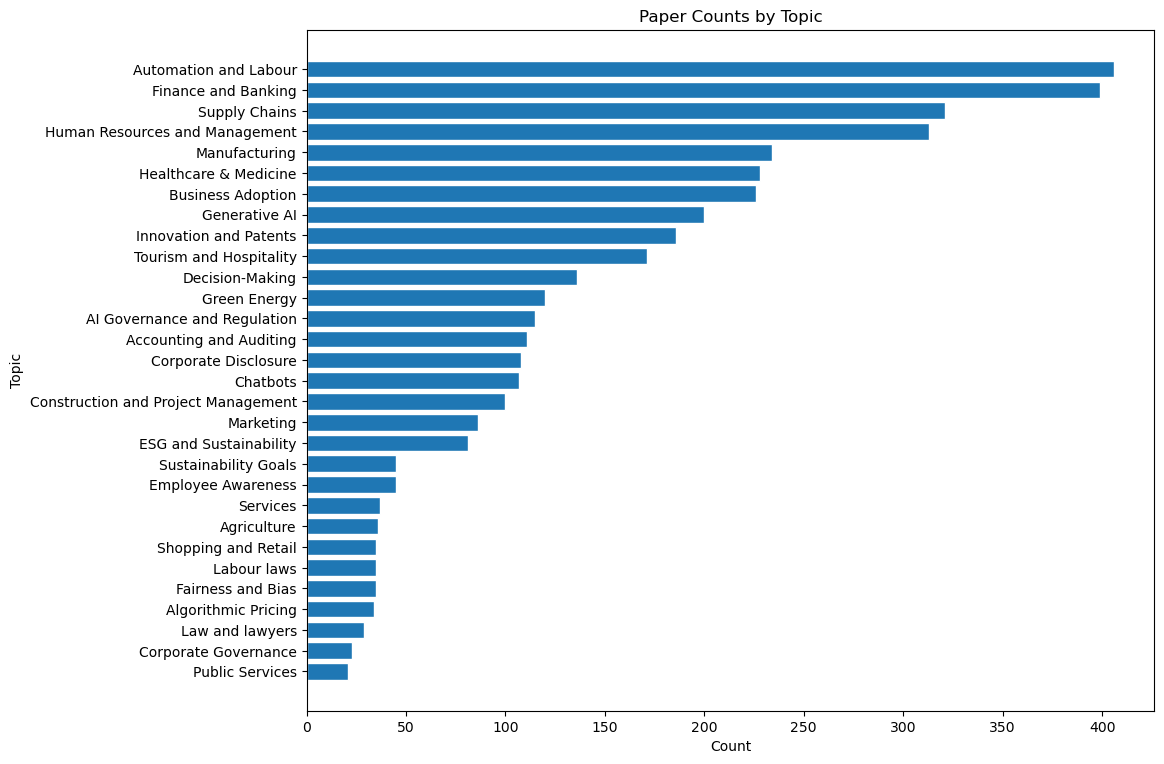

In [30]:
# Paper counts by topic

# Filter out the '-1' topic
proper_topics = topic_df[topic_df['Topic'] != -1]

# Sort by count (topic size)
proper_topics = proper_topics.sort_values('Count', ascending=True)

# Creating the bar chart
plt.figure(figsize=(12, 8))
plt.barh(proper_topics['Label'], proper_topics['Count'], edgecolor="white")
plt.xlabel("Count")
plt.ylabel("Topic")
plt.title("Paper Counts by Topic")
plt.tight_layout(pad=2)

# Saving the figure to a file
file_path = "images/combined_counts.pdf"
plt.savefig(file_path, format="pdf", bbox_inches="tight")
plt.show()

In [31]:
fig = topic_model.visualize_barchart(topics = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], custom_labels = True)
fig.show()
fig.write_image("images/combined_bars.pdf")

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [32]:
## Hierarchy

from scipy.cluster import hierarchy as sch

# Hierarchical topics
# linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
hierarchical_topics = topic_model.hierarchical_topics(documents)

fig = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
fig.show()

fig.write_image("images/combined_hierarchy.pdf")

100%|██████████| 31/31 [00:00<00:00, 733.66it/s]


In [33]:
fig = topic_model.visualize_topics(custom_labels = True)
fig.show()
fig.write_image("images/combined_intertopic_distances.pdf")

In [34]:
fig = topic_model.visualize_heatmap(topics = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], custom_labels = True, width = 800, height = 600)
fig.show()
fig.write_image("images/combined_similarity_matrix.pdf")

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Define your list of target words
target_words = ['adoption', 'innovation', 'work', 'business', 'ethical', 'responsible', 'risk', 'regulation', 'chatgpt'] # Add/remove words as needed

scores_per_topic_list = []

try:
    # Check if custom_topic_labels is defined
    if 'custom_topic_labels' not in locals() or not isinstance(custom_topic_labels, dict):
        raise NameError("Please define the 'custom_topic_labels' dictionary in the cell above.")

    c_tf_idf_matrix = topic_model.c_tf_idf_
    vocab_list = list(topic_model.vectorizer_model.get_feature_names_out())
    vocab_dict = {word: i for i, word in enumerate(vocab_list)}

    word_indices = {}
    found_words = []
    not_found_words = []
    for word in target_words:
        idx = vocab_dict.get(word)
        if idx is not None:
            word_indices[word] = idx
            found_words.append(word)
        else:
            not_found_words.append(word)

    if not_found_words:
        print(f"Warning: Words not found in vocabulary and will be skipped: {not_found_words}")

    if not found_words:
        print("Error: None of the target words were found in the vocabulary.")
    else:
        all_topic_ids = sorted(list(topic_model.get_topic_freq().Topic.unique()))
        if -1 in all_topic_ids:
            all_topic_ids.remove(-1)

        index_offset = 1 if -1 in topic_model.get_topic_freq().Topic.unique() else 0

        # Use custom_topic_labels for Topic Name
        for topic_id in all_topic_ids:
            topic_index = topic_id + index_offset

            if 0 <= topic_index < c_tf_idf_matrix.shape[0]:
                # *** Use custom label, fallback if topic_id not in dict ***
                topic_name = custom_topic_labels.get(topic_id, f"Topic {topic_id} (Custom label missing)")
                topic_data = {"Topic ID": topic_id, "Topic Name": topic_name}

                for word in found_words:
                    word_index = word_indices[word]
                    score = c_tf_idf_matrix[topic_index, word_index]
                    topic_data[word] = score

                scores_per_topic_list.append(topic_data)
            else:
                print(f"Warning: Topic index {topic_index} (for Topic ID {topic_id}) is out of bounds.")

        scores_df = pd.DataFrame(scores_per_topic_list)

        print(f"c-TF-IDF Scores for words {found_words} across all topics:")

        # --- Styling the DataFrame ---
        styled_df_to_render = None
        table_html = "" # Initialize table_html
        try:
            if not scores_df.empty:
                # *** Use 'Topic Name' (which now contains custom labels) as index ***
                df_to_style = scores_df.set_index('Topic Name')
                df_to_style = df_to_style[found_words]
                cmap = plt.get_cmap('Blues')
                format_dict = {word: "{:.4f}" for word in found_words}

                # Apply styling (gradient, format). Font is handled via CSS wrapper.
                styled_result = df_to_style.style.background_gradient(cmap=cmap, axis=0, subset=found_words) \
                                             .format(format_dict) \
                                             .set_properties(**{'text-align': 'right'}) # Align text right for scores

                styled_df_to_render = styled_result
                # Get the HTML for the table part
                table_html = styled_df_to_render.to_html()
            else:
                print("DataFrame is empty, nothing to style or save.")

        except Exception as style_error:
             print(f"Error during styling: {style_error}")
             styled_df_to_render = None
             table_html = ""


        # --- Display and Save ---
        if styled_df_to_render and table_html:
            print("Attempting to display styled DataFrame...")
            try:
                display(styled_df_to_render) # Display in Jupyter if possible

                # --- Construct Full HTML Document with Roboto Font and Save ---
                output_html_filename = 'styled_topic_word_scores_roboto.html'
                full_html = f"""
<!DOCTYPE html>
<html>
<head>
    <meta charset="utf-8">
    <title>Styled Topic Word Scores</title>
    <link href="https://fonts.googleapis.com/css2?family=Roboto:wght@400;700&display=swap" rel="stylesheet">
    <style>
        body {{
            font-family: 'Roboto', sans-serif;
            margin: 20px; /* Add some margin */
        }}
        table {{
            border-collapse: collapse; /* Nicer borders */
            margin: auto; /* Center table if desired */
            /* The Styler object usually adds its own table styles,
               but you can add overrides here if needed */
        }}
        th, td {{
            padding: 8px 12px; /* Add padding to cells */
            text-align: right; /* Default alignment */
        }}
        th {{
             background-color: #f2f2f2; /* Light grey header */
             font-weight: bold;
        }}
        /* Align the index (Topic Name) left */
        th.row_heading, td.row_heading {{
             text-align: left;
        }}

    </style>
</head>
<body>
    {table_html}
</body>
</html>
"""
                try:
                    print(f"Attempting to save full HTML document to {output_html_filename}...")
                    with open(output_html_filename, 'w', encoding='utf-8') as f:
                        f.write(full_html)
                    print(f"Successfully saved styled table with Roboto font to {output_html_filename}")
                except Exception as export_error:
                    print(f"Error saving styled DataFrame as HTML: {export_error}")

            except Exception as display_error:
                 print(f"Error displaying styled DataFrame: {display_error}")

        elif scores_df.empty and found_words:
             print("No scores to display or save (DataFrame was empty).")
        elif not found_words:
             print("No words found, nothing to display or save.")


except NameError as e:
     # Specific check for the custom labels dictionary
     if 'custom_topic_labels' in str(e):
         print("Error: 'custom_topic_labels' dictionary is not defined.")
         print("Please define it in the 'User Configuration' section of this cell.")
     else:
          print(f"NameError: {e}")
except AttributeError as e:
    if 'topic_model' in str(e) and 'c_tf_idf_' in str(e):
         print(f"Error: Could not access necessary attributes (like c_tf_idf_) from 'topic_model'. Is the model loaded and fitted correctly? Details: {e}")
    else:
         print(f"AttributeError: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


c-TF-IDF Scores for words ['adoption', 'innovation', 'work', 'business', 'ethical', 'responsible', 'risk', 'regulation', 'chatgpt'] across all topics:
Attempting to display styled DataFrame...


,adoption,innovation,work,business,ethical,responsible,risk,regulation,chatgpt
Topic Name,,,,,,,,,
Automation and Labour,0.0059,0.0031,0.0125,0.0023,0.0003,0.0001,0.0057,0.0008,0.0006
Finance and Banking,0.0065,0.0036,0.0027,0.0063,0.0041,0.0017,0.0127,0.0049,0.0004
Supply Chains,0.0052,0.0027,0.0025,0.0066,0.0002,0.0002,0.0093,0.0001,0.0007
Human Resources and Management,0.0106,0.0027,0.0114,0.0057,0.0054,0.0011,0.0009,0.0001,0.0005
Manufacturing,0.0063,0.0040,0.0037,0.0079,0.0012,0.0024,0.0020,0.0001,0.0000
Business Adoption,0.0220,0.0249,0.0055,0.0257,0.0017,0.0008,0.0023,0.0008,0.0005
Generative AI,0.0037,0.0041,0.0060,0.0087,0.0086,0.0031,0.0010,0.0014,0.0606
Healthcare & Medicine,0.0093,0.0037,0.0033,0.0027,0.0116,0.0009,0.0080,0.0033,0.0002
Innovation and Patents,0.0063,0.0347,0.0027,0.0062,0.0008,0.0002,0.0014,0.0015,0.0000


Attempting to save full HTML document to styled_topic_word_scores_roboto.html...
Successfully saved styled table with Roboto font to styled_topic_word_scores_roboto.html


In [36]:
docs_df = pd.DataFrame({'abstract': documents})
docs_cits = docs_df.merge(data[['abstract', 'Cited by', 'year', 'title', 'author']], on = 'abstract', how = 'left')[['abstract', 'Cited by', 'year', 'title', 'author']]
docs_cits

,abstract,Cited by,year,title,author
0,Do stronger intellectual property rights incen...,0.0,2024.0,do stronger ipr incentivize female participati...,"higgins, matthew j"
1,Drawing insights from the field of innovation ...,32.0,2024.0,"old moats for new models: openness, control, a...","nagaraj, abhishek"
2,How will the emergence of ChatGPT and other fo...,19.0,2024.0,artificial intelligence and the skill premium,"veruete, mario"
3,David Ricardo initially believed machinery wou...,8.0,2024.0,learning from ricardo and thompson: machinery ...,"johnson, simon"
4,Timely and accurate measurement of AI use by f...,23.0,2024.0,tracking firm use of ai in real time: a snapsh...,"savage, keith"
...,...,...,...,...,...
4603,"Since the introduction of ChatGPT, the leading...",2.0,2024.0,Artificial intelligence and consumer behavior:...,Hermann E.; Puntoni S.
4604,IBM has deployed its Predictive Analytics for ...,1.0,2021.0,IBM predictive analytics reduces server downtime,Bogojeska J.; Giurgiu I.; Stark G.; Wiesmann D.
4605,Natural resources have long been considered a ...,0.0,2024.0,Nonlinear relationship between natural resourc...,Xie T.; Xu Y.; Li Y.
4606,Purpose: This study aims to explore the role t...,7.0,2023.0,The role of artificial intelligence in improvi...,Calvo A.V.; Franco A.D.; Frasquet M.


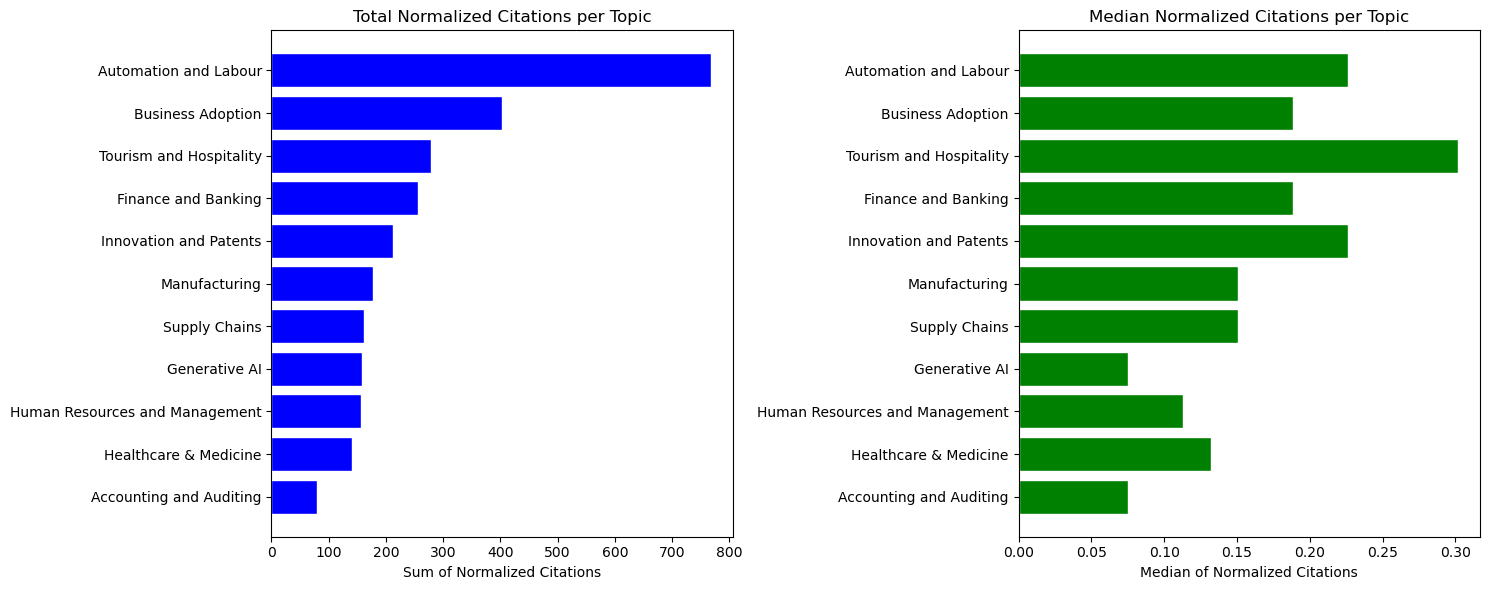

In [37]:
# find average citations
avg_citations = docs_cits['Cited by'].mean()

# Calculate normalized citations
docs_cits['normalized_citations'] = docs_cits['Cited by'] / avg_citations

# Merge with topic citations
docs_cits = docs_cits.merge(papers_topics[['abstract', 'Topic']], on='abstract', how='left')

# create a new topics_citations dataframe with normalized values
topics_normalized_citations = docs_cits.groupby('Topic').agg(
    sum_norm_citations=('normalized_citations', 'sum'),
    med_norm_citations=('normalized_citations', 'median'),
    count=('normalized_citations', 'count')
).reset_index()

# Apply labels
topics_normalized_citations['Label'] = topics_normalized_citations['Topic'].apply(lambda x: custom_topic_labels[x])
topics_normalized_citations = topics_normalized_citations[(topics_normalized_citations['Topic'] <= 10) &
                                                         (topics_normalized_citations['Topic'] != -1)]
topics_normalized_citations = topics_normalized_citations.sort_values(by='sum_norm_citations', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Total Normalized Citations bar chart
axes[0].barh(topics_normalized_citations['Label'], topics_normalized_citations['sum_norm_citations'],
            color='blue', edgecolor="white")
axes[0].set_title("Total Normalized Citations per Topic")
axes[0].set_xlabel("Sum of Normalized Citations")
axes[0].invert_yaxis()  # Invert y-axis for better readability

# Median Normalized Citations bar chart
axes[1].barh(topics_normalized_citations['Label'], topics_normalized_citations['med_norm_citations'],
            color='green', edgecolor="white")
axes[1].set_title("Median Normalized Citations per Topic")
axes[1].set_xlabel("Median of Normalized Citations")
axes[1].invert_yaxis()  # Ensure both y-axes match

# Adjust layout and save
plt.tight_layout()
plt.show()

file_path_norm_cits = "images/combined_normalized_citations_by_topic.pdf"
fig.savefig(file_path_norm_cits, format="pdf", bbox_inches="tight")

In [38]:
# Get the top 5 papers from Topic 4 (Innovation) by citation count
top_papers = papers_topics_full[papers_topics_full['Topic'] == 4].sort_values(by='Cited by', ascending=False).head()

# Display the full abstracts along with other information
pd.set_option('display.max_colwidth', None)  # Ensure full text display
display(top_papers[['abstract', 'Cited by', 'Question', 'subtopic', 'subtopic name']])
pd.reset_option('display.max_colwidth')  # Reset to default

,abstract,Cited by,Question,subtopic,subtopic name
1439,"Overview: The development of novel digital technologies connected to the Internet of Things, along with advancements in artificial intelligence and automation, is enabling a new wave of manufacturing innovation. “Smart factories” will leverage industrial equipment that communicates with users and with other machines, automated processes, and mechanisms to facilitate real-time communication between the factory and the market to support dynamic adaptation and maximize efficiency. Smart factories can yield a range of benefits, such as increased process efficiency, product quality, sustainability, and safety and decreased costs. However, companies face immense challenges in implementing smart factories, given the large-scale, systemic transformation the move requires. We use data gathered from in-depth studies of five factories in two leading automotive manufacturers to analyze these challenges and identify the key steps needed to implement the smart factory concept. Based on our analysis, we offer a preliminary maturity model for smart factory implementation built around three overarching principles: cultivating digital people, introducing agile processes, and configuring modular technologies. © 2018, © 2018 The Author(s). Published by Informa UK Limited, trading as Taylor & Francis Group.",308.0,"What are the key challenges and steps for implementing smart factories in the automotive industry, and how can a maturity model guide this transformation?",-1.0,-1_manufacturing_production_data_digital
3818,"Big data analytics and artificial intelligence (BDA-AI) technologies have attracted increasing interest in recent years from academics and practitioners. However, few empirical studies have investigated the benefits of BDA-AI in the supply chain integration process and its impact on environmental performance. To fill this gap, we extended the organizational information processing theory by integrating BDA-AI and positioning digital learning as a moderator of the green supply chain process. We developed a conceptual model to test a sample of data from 168 French hospitals using a partial least squares regression-based structural equation modeling method. The findings showed that the use of BDA-AI technologies has a significant effect on environmental process integration and green supply chain collaboration. The study also underlined that both environmental process integration and green supply chain collaboration have a significant impact on environmental performance. The results highlight the moderating role of green digital learning in the relationships between BDA-AI and green supply chain collaboration, a major finding that has not been highlighted in the extant literature. This article provides valuable insight for logistics/supply chain managers, helping them in mobilizing BDA-AI technologies for supporting green supply processes and enhancing environmental performance. © 2020",286.0,"What is the impact of big data analytics and artificial intelligence on supply chain integration and environmental performance, and how does digital learning moderate this relationship?",0.0,0_ce_circular_economy_supply
1965,"The circular economy (CE) has the potential to capitalise upon emerging digital technologies, such as big data, artificial intelligence (AI), blockchain and the Internet of things (IoT), amongst others. These digital technologies combined with business model innovation are deemed to provide solutions to myriad problems in the world, including those related to circular economy transformation. Given the societal and practical importance of CE and digitalisation, last decade has witnessed a significant increase in academic publication on these topics. Therefore, this study aims to capture the essence of the scholarly work at the intersection of the CE and digital technologies. A detailed analysis of the literature based on emerging themes was conducted with a focus on illum

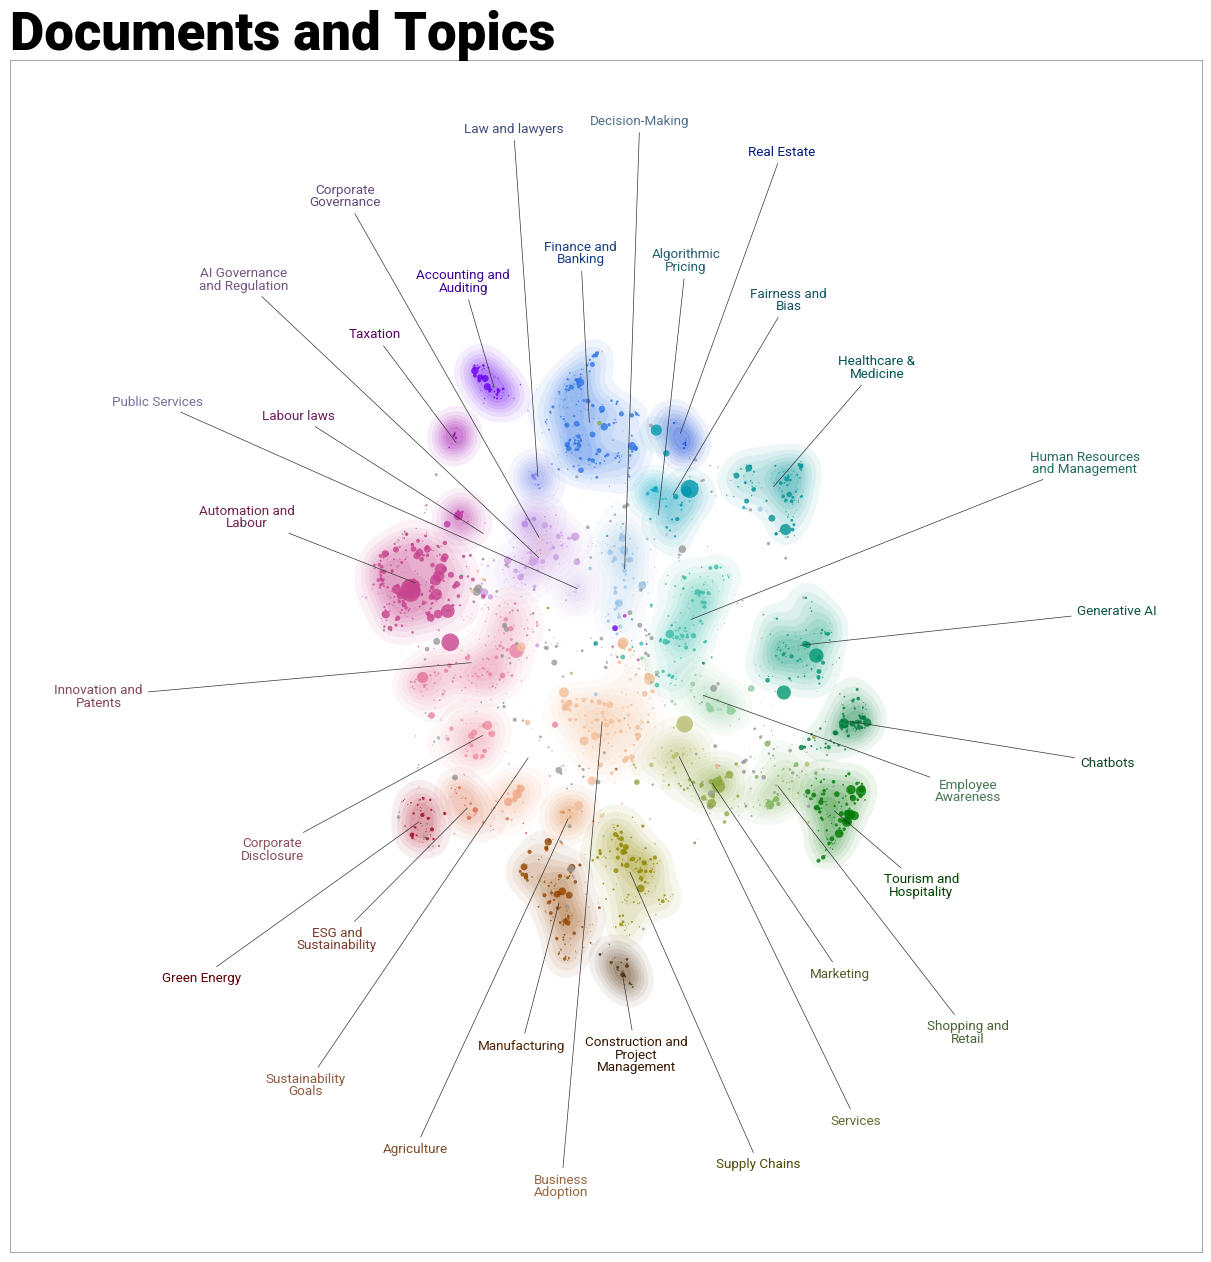

In [39]:
citations = docs_cits['Cited by'].to_list()
scaled_citations = [2*(c / max(citations)) * 100 for c in citations]
fig = topic_model.visualize_document_datamap(documents, custom_labels = True, embeddings=embeddings, point_size=scaled_citations)
fig.show()
fig.savefig("images/combined_landscape.pdf", dpi=600, bbox_inches='tight')

# Interactive Plot

In [40]:
import matplotlib.colors as mcolors
import umap
import datamapplot
import numpy as np
from sentence_transformers import SentenceTransformer
import numpy as np
import plotly.io as pio
import datamapplot
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import glasbey

In [41]:
# -----------------------------------------------------------------------------
# 1. Re‐encode abstracts for the filtered dataset (docs_cits)
# -----------------------------------------------------------------------------

# Reduce the embeddings to 2D for plotting.
umap_reducer = umap.UMAP(n_components=2, random_state=42, low_memory = False, n_jobs = 1)
data_map = umap_reducer.fit_transform(embeddings)

# -----------------------------------------------------------------------------
# 2. Compute the marker sizes by scaling the citation counts.
# -----------------------------------------------------------------------------
# Convert citation counts to float and scale so the maximum marker size is 50.
citations = docs_cits["Cited by"].astype(float).values
scaled_citations = np.asarray(10 + 40 * np.log10(1+ citations) / np.log10(1+ citations.max()))

# -----------------------------------------------------------------------------
# 3. Create custom hover text.
# -----------------------------------------------------------------------------
# Each entry will show the paper’s title, authors and citation count.
hover_text = [
    f"Title: {title}Authors: {authors} Citations: {cit}"
    for title, authors, cit in zip(docs_cits['title'], docs_cits['author'], docs_cits["Cited by"])
]

# -----------------------------------------------------------------------------
# 4. Prepare a label layer from your BERTopic output.
# -----------------------------------------------------------------------------

# Map each topic number to a custom topic label.
label_layer = [
    custom_topic_labels[t] if t in custom_topic_labels else str(t)
    for t in docs_cits['Topic']
]

# -----------------------------------------------------------------------------
# 5. Assign custom colours using Glasbey palette.
# -----------------------------------------------------------------------------
# First create a mapping from topic numbers to labels
topic_to_label = {}
for t in set(docs_cits['Topic']):
    if t in custom_topic_labels:
        topic_to_label[t] = custom_topic_labels[t]
    else:
        topic_to_label[t] = str(t)

# Now create your label layer using these labels
label_layer = [topic_to_label[t] for t in docs_cits['Topic']]

# Get a list of unique topics excluding -1
positive_topics = [t for t in set(docs_cits['Topic']) if t >= 0]
num_positive_topics = len(positive_topics)

# Import glasbey and generate a palette
import glasbey

# Generate a Glasbey palette with good perceptual distinction
colors = glasbey.create_palette(num_positive_topics, chroma_bounds=(30, 80), lightness_bounds=(25, 75))

# Create your custom colors dictionary mapping LABELS to colors
label_color_map = {}

# Assign Glasbey colors to positive topics
for i, t in enumerate(positive_topics):
    # Get color from Glasbey palette
    color = colors[i]
    # Convert to hex color string using matplotlib for robustness
    hex_color = mcolors.to_hex(color, keep_alpha=False)
    label_color_map[topic_to_label[t]] = hex_color

# Assign grey to topic -1 if it exists
if -1 in set(docs_cits['Topic']):
    label_color_map[topic_to_label[-1]] = "#b3b3b3"  # Light grey in hex

# Handle any empty string labels that might exist
if '' in label_layer:
    label_color_map[''] = "#b3b3b3"  # Light grey in hex

# -----------------------------------------------------------------------------
# 6. Create the interactive DataMapPlot.
# -----------------------------------------------------------------------------
plot = datamapplot.create_interactive_plot(
    data_map,
    label_layer,
    hover_text = hover_text,
    font_family = "Roboto",
    min_fontsize=14,
    max_fontsize=14,
    initial_zoom_fraction=0.8,
    marker_size_array = scaled_citations,
    title = "The Economics of AI Landscape",
    sub_title = "Data map of Economics of AI papers; scaled by citations",
    enable_search = True,
    label_color_map=label_color_map,
    on_click='let fullText = `{hover_text}`; let titleEnd = fullText.indexOf("Authors:"); let title = fullText.substring(7, titleEnd); window.open(`http://google.com/search?q=${encodeURIComponent(title)}`);',
    darkmode = False,
)

# Optionally, save the plot to an HTML file for sharing.
plot.save("AI_Landscape_Interactive.html")